In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
import json

# Configuration Variables
FILE_PATH = '19.6.2025.csv'
SELECTED_FEATURES = ['x_snap', 'y_snap', 'timestamp']
LOOK_BACK = 20 # Number of previous time steps to look at for prediction
PREDICT_AHEAD_STEPS = 10 # Number of future time steps to predict

# Data Split Ratios (70% train, 10% validation, 10% test)
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Directory for saving outputs
output_result = 'output_result'

# Ensure directories exist
os.makedirs(output_result, exist_ok=True)


# Set device for PyTorch (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("Starting BLE Direction Prediction Script (PyTorch Notebook Version)...")
print(f"File Path: {FILE_PATH}")
print(f"Selected Features: {SELECTED_FEATURES}")
print(f"Look-back window (input sequence length): {LOOK_BACK}")
print(f"Prediction Horizon (output steps): {PREDICT_AHEAD_STEPS}")
print(f"Data Split: Train {TRAIN_RATIO*100}%, Val {VAL_RATIO*100}%, Test {TEST_RATIO*100}%")

Using device: cpu
Starting BLE Direction Prediction Script (PyTorch Notebook Version)...
File Path: 19.6.2025.csv
Selected Features: ['x_snap', 'y_snap', 'timestamp']
Look-back window (input sequence length): 20
Prediction Horizon (output steps): 10
Data Split: Train 70.0%, Val 10.0%, Test 10.0%


# 1. Load Data

In [2]:
print("\n--- 1. Data Loading ---")

# Load the dataset
df = pd.read_csv(FILE_PATH)
df = df[SELECTED_FEATURES]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp').reset_index(drop=True)
print(f"Data Loaded Successfully. Initial Shape: {df.shape}")
original_df_for_plotting = df.copy() # Keep a copy for plotting original path



--- 1. Data Loading ---
Data Loaded Successfully. Initial Shape: (105, 3)


# 2. Data Preprocess


--- 2. Data Preprocessing (IQR Outlier Removal and Scaling) ---
  Applying IQR outlier removal for 'x_snap' and 'y_snap'...
  Removed 0 outliers (0.00%).
  Data shape after outlier removal: (105, 3)


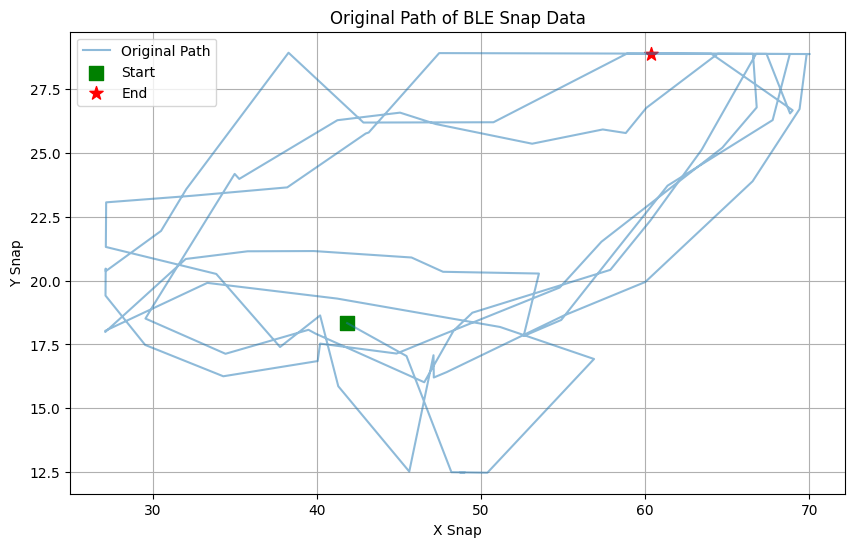

In [3]:
print("\n--- 2. Data Preprocessing (IQR Outlier Removal and Scaling) ---")
initial_rows = df.shape[0]

# --- IQR Outlier Removal ---
print("  Applying IQR outlier removal for 'x_snap' and 'y_snap'...")
filtered_df = df.copy()
for col in ['x_snap', 'y_snap']:
    Q1 = filtered_df[col].quantile(0.25)
    Q3 = filtered_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter rows where the column value is within the IQR bounds
    filtered_df = filtered_df[(filtered_df[col] >= lower_bound) & (filtered_df[col] <= upper_bound)]

rows_after_filter = filtered_df.shape[0]
print(f"  Removed {initial_rows - rows_after_filter} outliers ({(initial_rows - rows_after_filter)/initial_rows:.2%}).")
print(f"  Data shape after outlier removal: {filtered_df.shape}")

# Plot original path before scaling
plt.figure(figsize=(10, 6))
plt.plot(original_df_for_plotting['x_snap'], original_df_for_plotting['y_snap'], label='Original Path', alpha=0.5)
plt.scatter(original_df_for_plotting['x_snap'].iloc[0], original_df_for_plotting['y_snap'].iloc[0], color='green', s =100, marker='s', label='Start')
plt.scatter(original_df_for_plotting['x_snap'].iloc[-1], original_df_for_plotting['y_snap'].iloc[-1], color='red', s=100, marker='*', label='End')
plt.title('Original Path of BLE Snap Data')
plt.xlabel('X Snap')
plt.ylabel('Y Snap')
plt.legend()
plt.grid()
plt.savefig(os.path.join(output_result, 'original_path.png'))


In [4]:
# Scaling
data_for_scaling = filtered_df[['x_snap', 'y_snap']].values
n_features = data_for_scaling.shape[1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_for_scaling)
print("  MinMaxScaler applied to x_snap and y_snap.")

  MinMaxScaler applied to x_snap and y_snap.


# 3. Model Definition

In [5]:
print("\n--- 3. Defining PyTorch Dataset Class ---")
class BLEDataset(Dataset):
    def __init__(self, data, look_back, predict_ahead_steps):
        self.look_back = look_back
        self.predict_ahead_steps = predict_ahead_steps
        self.X, self.y = self._create_sequences(data)

    def _create_sequences(self, data):
        X, y = [], []
        for i in range(len(data) - self.look_back - self.predict_ahead_steps + 1):
            X.append(data[i:(i + self.look_back), :])
            y.append(data[(i + self.look_back):(i + self.look_back + self.predict_ahead_steps), :].flatten())
        return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
print("  BLEDataset class defined.")


--- 3. Defining PyTorch Dataset Class ---
  BLEDataset class defined.


# 4. Create Datasets and DataLoaders

In [6]:
print("\n--- 4. Creating PyTorch Datasets and DataLoaders ---")
full_dataset = BLEDataset(scaled_data, LOOK_BACK, PREDICT_AHEAD_STEPS)

if len(full_dataset) == 0:
    print("Error: Not enough data points to create sequences after preprocessing. Cannot proceed.")
    exit()

total_sequences_in_dataset = len(full_dataset)
train_split_idx = int(total_sequences_in_dataset * TRAIN_RATIO)
val_split_idx = train_split_idx + int(total_sequences_in_dataset * VAL_RATIO)
test_split_idx = val_split_idx + int(total_sequences_in_dataset * TEST_RATIO)


--- 4. Creating PyTorch Datasets and DataLoaders ---


In [7]:
# Ensure valid splits
if train_split_idx == 0 or val_split_idx <= train_split_idx or test_split_idx <= val_split_idx:
    print(f"Error: Not enough data to create valid train/val/test splits with current ratios ({TRAIN_RATIO}, {VAL_RATIO}, {TEST_RATIO}) and data length ({total_sequences_in_dataset} sequences). Adjust ratios or collect more data.")
    exit()

X_train = full_dataset.X[:train_split_idx]
y_train = full_dataset.y[:train_split_idx]

X_val = full_dataset.X[train_split_idx:val_split_idx]
y_val = full_dataset.y[train_split_idx:val_split_idx]

X_test = full_dataset.X[val_split_idx:test_split_idx]
y_test = full_dataset.y[val_split_idx:test_split_idx]

In [8]:
# For final prediction: use the very last `LOOK_BACK` actual data points after filtering
if len(scaled_data) < LOOK_BACK:
    print(f"Error: Not enough data ({len(scaled_data)} points) to form the final prediction input sequence (requires {LOOK_BACK} points).")
    exit()
final_predict_input_sequence = torch.tensor(scaled_data[-LOOK_BACK:], dtype=torch.float32).reshape(1, LOOK_BACK, n_features)

print(f"  Train set shape (X, y): {X_train.shape}, {y_train.shape}")
print(f"  Validation set shape (X, y): {X_val.shape}, {y_val.shape}")
print(f"  Test set shape (X, y): {X_test.shape}, {y_test.shape}")
print(f"  Final prediction input sequence shape: {final_predict_input_sequence.shape}")
print(f"  Note: The final prediction input uses the last '{LOOK_BACK}' available actual data points after filtering.")

  Train set shape (X, y): torch.Size([53, 20, 2]), torch.Size([53, 20])
  Validation set shape (X, y): torch.Size([7, 20, 2]), torch.Size([7, 20])
  Test set shape (X, y): torch.Size([7, 20, 2]), torch.Size([7, 20])
  Final prediction input sequence shape: torch.Size([1, 20, 2])
  Note: The final prediction input uses the last '20' available actual data points after filtering.


# 5. Define Model Class Class

In [9]:
print("\n--- 5. Defining PyTorch LSTM Model Class ---")
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True) 
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0_1 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c0_1 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        out1, _ = self.lstm1(x, (h0_1, c0_1))
        out1 = self.dropout1(out1)

        h0_2 = torch.zeros(1, out1.size(0), self.hidden_size).to(device)
        c0_2 = torch.zeros(1, out1.size(0), self.hidden_size).to(device)
        out2, _ = self.lstm2(out1, (h0_2, c0_2)) 
        out_last_step = out2[:, -1, :] # Take the last element of the sequence dimension

        out = self.fc(out_last_step)
        return out
print("  LSTMModel class defined.")


--- 5. Defining PyTorch LSTM Model Class ---
  LSTMModel class defined.


# 6. Model Training Loop (Iterate Optimizers)

In [10]:
# --- Cell 7: Model Training Loop (Iterate Optimizers) ---
print("\n--- 7. Model Training Loop (Iterating Optimizers) ---")

input_size = n_features # Number of features per time step (x, y)
output_size = PREDICT_AHEAD_STEPS * n_features # Flattened output (10 * 2 = 20)
hidden_size = 100 # Consistent with previous examples
epochs = 50
batch_size = 32

optimizers_to_test = ['adam', 'sgd', 'adamw', 'rmsprop', 'adagrad']
all_histories = {}
best_optimizer_name = None
best_model_state_dict_path = None


train_dataset_loader = DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_dataset_loader = DataLoader(torch.utils.data.TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_dataset_loader = DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False) # For evaluation later


--- 7. Model Training Loop (Iterating Optimizers) ---


In [11]:
for opt_name in optimizers_to_test:
    print(f"\n===== Training with Optimizer: {opt_name.upper()} =====")
    
    # Instantiate Model for current optimizer
    model = LSTMModel(input_size, hidden_size, output_size).to(device)

    # Define Optimizer and Loss Function
    if opt_name == 'adam':
        optimizer = torch.optim.Adam(model.parameters())
    elif opt_name == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    elif opt_name == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters())
    elif opt_name == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters())
    elif opt_name == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters())
    
    criterion = nn.MSELoss()

    history = {'loss': [], 'val_loss': []}
    current_best_val_loss_for_optimizer = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        total_train_loss = 0
        for batch_X, batch_y in train_dataset_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataset_loader)
        history['loss'].append(avg_train_loss)

         # --- Validation Phase ---
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch_X_val, batch_y_val in val_dataset_loader:
                batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
                outputs_val = model(batch_X_val)
                val_loss = criterion(outputs_val, batch_y_val)
                total_val_loss += val_loss.item()
                
        avg_val_loss = total_val_loss / len(val_dataset_loader)
        history['val_loss'].append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # --- Early Stopping ---
        if avg_val_loss < current_best_val_loss_for_optimizer:
            current_best_val_loss_for_optimizer = avg_val_loss
            patience_counter = 0
            
        else:
            patience_counter += 1
            if patience_counter >= 10:
                print(f"Early stopping at epoch {epoch+1} as validation loss did not improve for 10 epochs.")
            
        print(f"Training with {opt_name.upper()} completed.")

                # Evaluate model on Test Set
        print(f"  Running Inference for {opt_name.upper()} on Test Set...")
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for batch_X_test, batch_y_test in test_dataset_loader:
                batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
                outputs_test = model(batch_X_test)
                test_loss = criterion(outputs_test, batch_y_test)
                total_test_loss += test_loss.item()
            
        avg_test_loss = total_test_loss / len(test_dataset_loader)
        print(f"  Test Loss for {opt_name.upper()}: {avg_test_loss:.4f}")

        # --- Save Training History as JSON ---
        history_data = {key: [float(val) for val in values] for key, values in history.items()}
        history_path = os.path.join(output_result, f'history_{opt_name}.json')
        with open(history_path, 'w') as f:
            json.dump(history_data, f)
        print(f"  Training history saved for {opt_name.upper()} at: {history_path}")

        # --- Save Model State Dict (ALWAYS) ---
        model_save_path = os.path.join(output_result, f'model_{opt_name}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f"  ✅ Model saved for {opt_name.upper()} at: {model_save_path}")
    
    all_histories[opt_name] = history



===== Training with Optimizer: ADAM =====
Epoch [1/50], Train Loss: 0.3943, Val Loss: 0.5875
Training with ADAM completed.
  Running Inference for ADAM on Test Set...
  Test Loss for ADAM: 0.2222
  Training history saved for ADAM at: output_result/history_adam.json
  ✅ Model saved for ADAM at: output_result/model_adam.pth
Epoch [2/50], Train Loss: 0.3887, Val Loss: 0.5527
Training with ADAM completed.
  Running Inference for ADAM on Test Set...
  Test Loss for ADAM: 0.2019
  Training history saved for ADAM at: output_result/history_adam.json
  ✅ Model saved for ADAM at: output_result/model_adam.pth
Epoch [3/50], Train Loss: 0.3553, Val Loss: 0.5120
Training with ADAM completed.
  Running Inference for ADAM on Test Set...
  Test Loss for ADAM: 0.1785
  Training history saved for ADAM at: output_result/history_adam.json
  ✅ Model saved for ADAM at: output_result/model_adam.pth
Epoch [4/50], Train Loss: 0.3169, Val Loss: 0.4587
Training with ADAM completed.
  Running Inference for ADAM o

# 7. Plotting

In [12]:
print("\n--- 7. Plotting Results ---")

# Plotting individual training histories
for opt_name, history in all_histories.items():
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {opt_name.upper()}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(output_result, f'loss_plot_{opt_name}.png')
    plt.savefig(plot_path)
    plt.close()
    print(f"  Loss plot for {opt_name.upper()} saved at: {plot_path}")

print('\nHistories available for plotting:', list(all_histories.keys()))


--- 7. Plotting Results ---
  Loss plot for ADAM saved at: output_result/loss_plot_adam.png
  Loss plot for SGD saved at: output_result/loss_plot_sgd.png
  Loss plot for ADAMW saved at: output_result/loss_plot_adamw.png
  Loss plot for RMSPROP saved at: output_result/loss_plot_rmsprop.png
  Loss plot for ADAGRAD saved at: output_result/loss_plot_adagrad.png

Histories available for plotting: ['adam', 'sgd', 'adamw', 'rmsprop', 'adagrad']


In [13]:
# Plotting all training losses for comparison
plt.figure(figsize=(12, 8))
for opt_name, history in all_histories.items():
    plt.plot(history['loss'], label=f'{opt_name.upper()} Training Loss')
plt.title('Comparison of Training Losses Across Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plot_path = os.path.join(output_result, 'all_training_losses_comparison.png')
plt.savefig(plot_path)
plt.close()
print(f"  Comparison plot of all training losses saved at: {plot_path}")

  Comparison plot of all training losses saved at: output_result/all_training_losses_comparison.png


# 8. Prediction 

Predicting next 10 steps...

 -- Ground Trutth vs Predicted (10 steps ahead) ---
Step 1: GT=(35.27, 23.99) | Pred=(36.49, 23.99) | Error=1.22
Step 2: GT=(34.99, 24.19) | Pred=(33.07, 23.10) | Error=2.20
Step 3: GT=(30.03, 19.02) | Pred=(32.27, 22.03) | Error=3.76
Step 4: GT=(29.56, 18.52) | Pred=(30.61, 21.24) | Error=2.92
Step 5: GT=(34.44, 17.14) | Pred=(31.81, 20.17) | Error=4.01
Step 6: GT=(39.49, 18.07) | Pred=(31.80, 19.23) | Error=7.78
Step 7: GT=(39.93, 17.92) | Pred=(33.94, 18.19) | Error=6.00
Step 8: GT=(46.54, 16.02) | Pred=(36.27, 17.67) | Error=10.40
Step 9: GT=(48.33, 18.04) | Pred=(38.16, 17.12) | Error=10.21
Step 10: GT=(49.47, 18.74) | Pred=(41.41, 17.30) | Error=8.19

Mean Error: 5.67, Max Error: 10.40


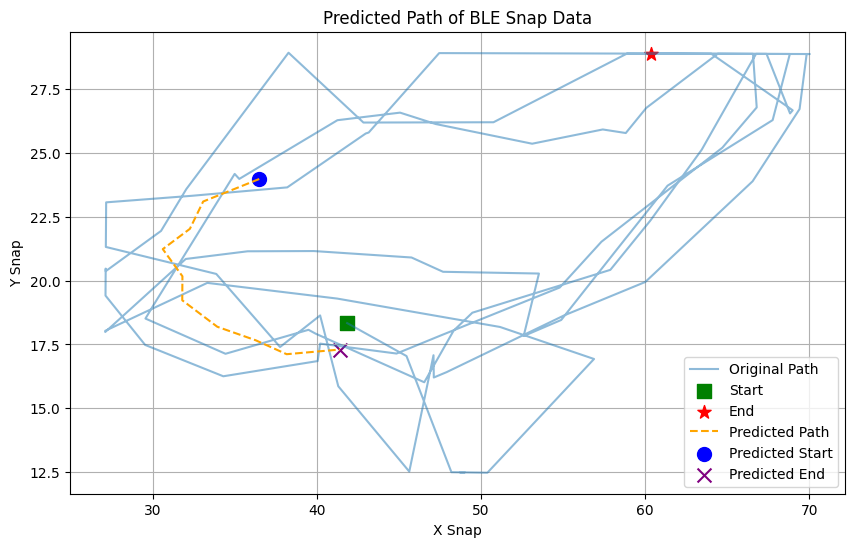

In [14]:
# Load model
final_model = LSTMModel(input_size, hidden_size, output_size).to(device)
final_model.load_state_dict(torch.load(model_save_path))
final_model.eval()
final_predict_input_sequence = X_test[-1].unsqueeze(0)  # Reshape to (1, LOOK_BACK, n_features)
y_ground = y_test[-1]  # Get the last ground truth for comparison

print(f"Predicting next {PREDICT_AHEAD_STEPS} steps...")
final_predict_input_sequence = final_predict_input_sequence.to(device)

with torch.no_grad():
    predicted_scaled_tensor = final_model(final_predict_input_sequence)

predicted_scaled = predicted_scaled_tensor.cpu().numpy()
predicted_scaled = predicted_scaled.reshape(PREDICT_AHEAD_STEPS, n_features)

# Inverse transform to original scale
predicted_coords = scaler.inverse_transform(predicted_scaled)

# Ground truth for Comparison
true_coords = scaler.inverse_transform(y_ground.cpu().numpy().reshape(-1, n_features))

# Compute per-step errors (Euclidean Distance)
errors = np.linalg.norm(predicted_coords - true_coords, axis=1)  #shape:(10,)
mean_error = np.mean(errors)
max_error = np.max(errors)

# Print Comparison
print('\n -- Ground Trutth vs Predicted (10 steps ahead) ---')
for i in range(PREDICT_AHEAD_STEPS):
    pred = predicted_coords[i]
    truth = true_coords[i]
    err = errors[i]
    print(f"Step {i+1}: GT=({truth[0]:.2f}, {truth[1]:.2f}) | Pred=({pred[0]:.2f}, {pred[1]:.2f}) | Error={err:.2f}")
print(f"\nMean Error: {mean_error:.2f}, Max Error: {max_error:.2f}")
# Plotting the predicted path

plt.figure(figsize=(10, 6))
plt.plot(original_df_for_plotting['x_snap'], original_df_for_plotting['y_snap'], label='Original Path', alpha=0.5)
plt.scatter(original_df_for_plotting['x_snap'].iloc[0], original_df_for_plotting['y_snap'].iloc[0], color='green', s=100, marker='s', label='Start')
plt.scatter(original_df_for_plotting['x_snap'].iloc[-1], original_df_for_plotting['y_snap'].iloc[-1], color='red', s=100, marker='*', label='End')
# Plot predicted path
predicted_df = pd.DataFrame(predicted_coords, columns=['x_snap', 'y_snap'])
plt.plot(predicted_df['x_snap'], predicted_df['y_snap'], label='Predicted Path', color='orange', linestyle='--')
plt.scatter(predicted_df['x_snap'].iloc[0], predicted_df['y_snap'].iloc[0], color='blue', s=100, marker='o', label='Predicted Start')
plt.scatter(predicted_df['x_snap'].iloc[-1], predicted_df['y_snap'].iloc[-1], color='purple', s=100, marker='x', label='Predicted End')
plt.title('Predicted Path of BLE Snap Data')
plt.xlabel('X Snap')
plt.ylabel('Y Snap')
plt.legend()
plt.grid()

In [15]:
# Plotting prediction path
if 'predicted_coords' in locals(): # Only plot if prediction was successful
    plt.figure(figsize=(12, 8))

    # Get the last 'LOOK_BACK' actual data points from the *filtered* original data for input visualization
    last_input_data_orig_filtered = filtered_df[['x_snap', 'y_snap']].tail(LOOK_BACK).values

    plt.plot(original_df_for_plotting['x_snap'], original_df_for_plotting['y_snap'], 'b-', label='Original Data Path (Pre-filter)', alpha=0.6)
    plt.plot(last_input_data_orig_filtered[:, 0], last_input_data_orig_filtered[:, 1], 'g-o', markersize=5, label=f'Last {LOOK_BACK} Input Points (Post-filter)')
    plt.plot(predicted_coords[:, 0], predicted_coords[:, 1], 'r-x', markersize=8, label=f'Predicted Next {PREDICT_AHEAD_STEPS} Steps')

    if len(last_input_data_orig_filtered) > 0:
        plt.scatter(last_input_data_orig_filtered[-1, 0], last_input_data_orig_filtered[-1, 1], color='purple', s=100, zorder=5, label='Last Input Point')
    if len(predicted_coords) > 0:
        plt.scatter(predicted_coords[0, 0], predicted_coords[0, 1], color='orange', s=100, zorder=5, label='First Predicted Point')
        plt.scatter(predicted_coords[-1, 0], predicted_coords[-1, 1], color='red', s=100, zorder=5, label='Last Predicted Point')

    plt.title(f'BLE Path: Last {LOOK_BACK} Steps and Predicted Next {PREDICT_AHEAD_STEPS} Steps')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plot_path = os.path.join(output_result, 'prediction_path_plot.png')
    plt.savefig(plot_path)
    plt.close()
    print(f"  Prediction path plot saved at: {plot_path}")
else:
    print("  Prediction path plot skipped as no prediction was made.")


  Prediction path plot saved at: output_result/prediction_path_plot.png


In [25]:
# --- Plot per-step Euclidean distance errors ---
plt.figure(figsize=(10, 6))
plt.stem(range(1, PREDICT_AHEAD_STEPS + 1), errors, basefmt=" ")
# plt.plot(range(1, PREDICT_AHEAD_STEPS + 1), errors, marker='o', linestyle='-', color='red')
plt.title('Per-Step Euclidean Error (Ground Truth vs Prediction)')
plt.xlabel('Step')
plt.ylabel('Error (distance units)')
plt.grid(True)
plt.xticks(range(1, PREDICT_AHEAD_STEPS + 1))
plt.tight_layout()

error_plot_path = os.path.join(output_result, 'prediction_error_plot.png')
plt.savefig(error_plot_path)
plt.close()
print(f"  Error plot saved at: {error_plot_path}")

  Error plot saved at: output_result/prediction_error_plot.png


In [17]:
# --- Create Comparison DataFrame ---
comparison_df = pd.DataFrame({
    'Step': np.arange(1, PREDICT_AHEAD_STEPS + 1),
    'GT_x': true_coords[:, 0],
    'GT_y': true_coords[:, 1],
    'Pred_x': predicted_coords[:, 0],
    'Pred_y': predicted_coords[:, 1],
    'Error_Distance': errors
})

# --- Save to CSV ---
comparison_csv_path = os.path.join(output_result, 'ground_truth_vs_prediction.csv')
comparison_df.to_csv(comparison_csv_path, index=False)
print(f"✅ CSV saved to: {comparison_csv_path}")

# --- Plot Ground Truth vs Predicted Path ---
plt.figure(figsize=(10, 8))
plt.plot(true_coords[:, 0], true_coords[:, 1], 'go-', label='Ground Truth Path')
plt.plot(predicted_coords[:, 0], predicted_coords[:, 1], 'rx--', label='Predicted Path')

# Start & End markers
plt.scatter(true_coords[0, 0], true_coords[0, 1], color='green', s=100, label='GT Start', marker='o')
plt.scatter(true_coords[-1, 0], true_coords[-1, 1], color='darkgreen', s=100, label='GT End', marker='o')

plt.scatter(predicted_coords[0, 0], predicted_coords[0, 1], color='red', s=100, label='Pred Start', marker='x')
plt.scatter(predicted_coords[-1, 0], predicted_coords[-1, 1], color='darkred', s=100, label='Pred End', marker='x')

plt.title('Ground Truth vs Predicted Path (10 Steps)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

# Save the plot
comparison_plot_path = os.path.join(output_result, 'ground_truth_vs_prediction_plot.png')
plt.savefig(comparison_plot_path)
plt.close()

print(f"📈 Plot saved to: {comparison_plot_path}")


✅ CSV saved to: output_result/ground_truth_vs_prediction.csv
📈 Plot saved to: output_result/ground_truth_vs_prediction_plot.png


In [18]:
# Historical path
original_path = original_df_for_plotting[['x_snap', 'y_snap']].values

plt.figure(figsize=(12, 8))

# Plot full trajectory
plt.plot(original_path[:, 0], original_path[:, 1], 'k-', alpha=0.3, label='History Trajectory')

# Plot ground truth and predicted paths
plt.plot(true_coords[:, 0], true_coords[:, 1], 'go-', label='Ground Truth (Next 10 Steps)')
plt.plot(predicted_coords[:, 0], predicted_coords[:, 1], 'rx--', label='Predicted Path')

# Draw filled area (polygon) between each GT and predicted point
for i in range(len(true_coords)-1):
    # Define polygon between GT[i] -> GT[i+1] and Pred[i] -> Pred[i+1]
    polygon_x = [true_coords[i, 0], true_coords[i+1, 0],
                 predicted_coords[i+1, 0], predicted_coords[i, 0]]
    polygon_y = [true_coords[i, 1], true_coords[i+1, 1],
                 predicted_coords[i+1, 1], predicted_coords[i, 1]]
    
    # Use alpha-shaded gray, or color by error if desired
    plt.fill(polygon_x, polygon_y, color='gray', alpha=0.3)

# Start and end points
plt.scatter(original_path[0, 0], original_path[0, 1], color='blue', s=100, label='Start (History)')
plt.scatter(original_path[-1, 0], original_path[-1, 1], color='navy', s=100, label='End (History)')
plt.scatter(true_coords[0, 0], true_coords[0, 1], color='green', s=100, label='GT Start', marker='o')
plt.scatter(true_coords[-1, 0], true_coords[-1, 1], color='darkgreen', s=100, label='GT End', marker='o')
plt.scatter(predicted_coords[0, 0], predicted_coords[0, 1], color='red', s=100, label='Pred Start', marker='x')
plt.scatter(predicted_coords[-1, 0], predicted_coords[-1, 1], color='darkred', s=100, label='Pred End', marker='x')

plt.title('Trajectory with Shaded Difference Between GT and Predicted Paths')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

# Save the plot
filled_diff_plot_path = os.path.join(output_result, 'trajectory_filled_difference.png')
plt.savefig(filled_diff_plot_path)
plt.close()

print(f"✅ Saved shaded path difference plot at:\n{filled_diff_plot_path}")


✅ Saved shaded path difference plot at:
output_result/trajectory_filled_difference.png


In [19]:
# Historical path (already loaded earlier)
original_path = original_df_for_plotting[['x_snap', 'y_snap']].values

plt.figure(figsize=(12, 8))

# --- Plot history ---
plt.plot(original_path[:, 0], original_path[:, 1], 'k-', alpha=0.3, label='History Trajectory')

# --- Plot ground truth and predicted paths ---
plt.plot(true_coords[:, 0], true_coords[:, 1], 'go-', label='Ground Truth Path')
plt.plot(predicted_coords[:, 0], predicted_coords[:, 1], 'rx--', label='Predicted Path')

# --- Plot Euclidean error lines step-by-step ---
for i in range(len(true_coords)):
    plt.plot(
        [true_coords[i, 0], predicted_coords[i, 0]],
        [true_coords[i, 1], predicted_coords[i, 1]],
        color='orange', linestyle='-', linewidth=2, alpha=0.7,
        label='Error Line' if i == 0 else ""  # Show label only once
    )

# --- Mark Start/End points ---
plt.scatter(original_path[0, 0], original_path[0, 1], color='blue', s=100, label='Start (History)')
plt.scatter(original_path[-1, 0], original_path[-1, 1], color='navy', s=100, label='End (History)')
plt.scatter(true_coords[0, 0], true_coords[0, 1], color='green', s=100, label='GT Start', marker='o')
plt.scatter(true_coords[-1, 0], true_coords[-1, 1], color='red', s=100, label='GT End', marker='o')
plt.scatter(predicted_coords[0, 0], predicted_coords[0, 1], color='red', s=100, label='Pred Start', marker='x')
plt.scatter(predicted_coords[-1, 0], predicted_coords[-1, 1], color='darkred', s=100, label='Pred End', marker='x')

# --- Final formatting ---
plt.title('GT vs Predicted Path with Euclidean Error Lines')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

# Save the plot
error_lines_plot_path = os.path.join(output_result, 'gt_vs_pred_error_lines.png')
plt.savefig(error_lines_plot_path)
plt.close()

print(f"✅ Saved plot with Euclidean error lines:\n{error_lines_plot_path}")


✅ Saved plot with Euclidean error lines:
output_result/gt_vs_pred_error_lines.png


'output_result/gt_vs_pred_real_coords.gif'

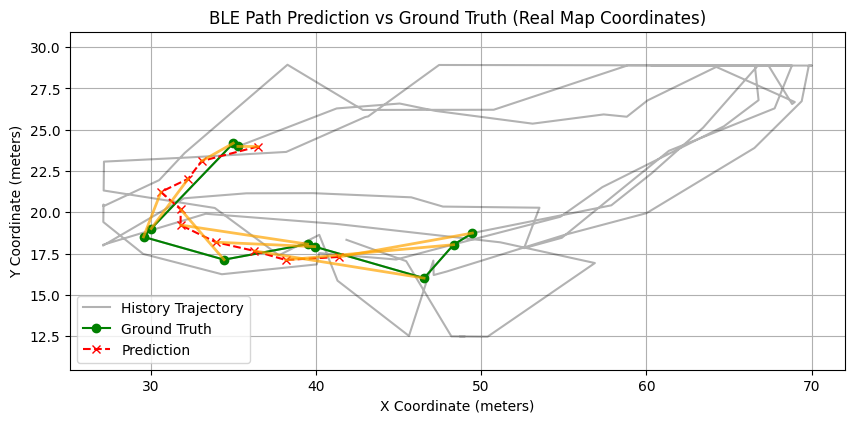

In [21]:
# Create animation again but using actual real-world coordinate range for visualization
from matplotlib import animation 

# Define figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot historical path as background
ax.plot(original_path[:, 0], original_path[:, 1], 'k-', alpha=0.3, label='History Trajectory')

# Initialize animated lines
gt_line, = ax.plot([], [], 'go-', label='Ground Truth')
pred_line, = ax.plot([], [], 'rx--', label='Prediction')
error_lines = []

# Real-world coordinates: use min/max of all involved data
x_all = np.concatenate([original_path[:, 0], true_coords[:, 0], predicted_coords[:, 0]])
y_all = np.concatenate([original_path[:, 1], true_coords[:, 1], predicted_coords[:, 1]])

# Set axis limits based on data
ax.set_xlim(np.min(x_all) - 2, np.max(x_all) + 2)
ax.set_ylim(np.min(y_all) - 2, np.max(y_all) + 2)
ax.set_title('BLE Path Prediction vs Ground Truth (Real Map Coordinates)')
ax.set_xlabel('X Coordinate (meters)')
ax.set_ylabel('Y Coordinate (meters)')
ax.legend()
ax.grid(True)
ax.set_aspect('equal', adjustable='box')

# Update function for animation
def update_real(frame):
    gt_line.set_data(true_coords[:frame+1, 0], true_coords[:frame+1, 1])
    pred_line.set_data(predicted_coords[:frame+1, 0], predicted_coords[:frame+1, 1])

    for line in error_lines:
        line.remove()
    error_lines.clear()

    for i in range(frame + 1):
        error_line, = ax.plot(
            [true_coords[i, 0], predicted_coords[i, 0]],
            [true_coords[i, 1], predicted_coords[i, 1]],
            color='orange', linestyle='-', linewidth=2, alpha=0.7
        )
        error_lines.append(error_line)

    return [gt_line, pred_line] + error_lines

# Create animation
ani_real = animation.FuncAnimation(fig, update_real, frames=PREDICT_AHEAD_STEPS, interval=800, blit=True)

# Save to GIF again using real-world coordinate scaling
real_map_gif_path = os.path.join(output_result, 'gt_vs_pred_real_coords.gif')
ani_real.save(real_map_gif_path, writer='pillow')

real_map_gif_path
